**Installing Necessary Libraries**

In [1]:
!pip install sentence-transformers scikit-learn pandas numpy


[notice] A new release of pip is available: 25.1.1 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


**Importing Necessary Libraries**

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

C:\Users\VAISHNAVI\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv("fake_news_dataset.csv")

# Filling null values
df['title'] = df['title'].fillna('')
df['text'] = df['text'].fillna('')

**Mapping Labels**

In [4]:
# Remove leading/trailing spaces and convert to lowercase
df['label'] = df['label'].str.strip().str.lower()

# Map to integers
df['label'] = df['label'].map({'real': 0, 'fake': 1})

# Drop rows that didn’t match 'real' or 'fake'
df = df[df['label'].notnull()]

# Convert to int
df['label'] = df['label'].astype(int)

# Safety check
assert df['label'].isnull().sum() == 0
print("Rows left after label processing:", len(df))


Rows left after label processing: 20000


In [5]:
df['content'] = df['title'] + " " + df['text']

**Loading Model for text processing**

In [6]:
model = SentenceTransformer('all-MiniLM-L6-v2')

X = model.encode(
    df['content'].tolist(),
    batch_size=32,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True
)

Batches: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [16:12<00:00,  1.56s/it]


**Setting y**

In [7]:
y = df['label'].values

**Train-Test Split**

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

**Using Logistic Regression for classification**

In [9]:
clf = LogisticRegression(max_iter=2000, class_weight='balanced', n_jobs=-1)
clf.fit(X_train, y_train)

C:\Users\VAISHNAVI\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :ter

**Evaluation**

In [10]:
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.492
F1 Score: 0.4912368552829244

Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.50      0.49      1989
           1       0.49      0.49      0.49      2011

    accuracy                           0.49      4000
   macro avg       0.49      0.49      0.49      4000
weighted avg       0.49      0.49      0.49      4000



Multi-Model Comparison Table

In [15]:
# Dictionary to store model evaluation metrics
# Anyone who runs a model should add its metrics here.
# Format:
# model_metrics['Model Name'] = {
#     "Accuracy": ...,
#     "Precision": ...,
#     "Recall": ...,
#     "F1-Score": ...
# }

model_metrics = {}

In [16]:
model_metrics["Random Forest"] = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1-Score": f1_score(y_test, y_pred)
}

In [31]:
#Summary Table

metrics_df = pd.DataFrame(model_metrics).T.reset_index().rename(columns={"index": "Model Name"})
print(metrics_df)

            Model Name  Accuracy  Precision    Recall  F1-Score
0        Random Forest   0.49200   0.494705  0.487817  0.491237
1              XGBoost   0.49600   0.498738  0.491298  0.494990
2  Tuned Random Forest   0.48625   0.489320  0.501243  0.495210


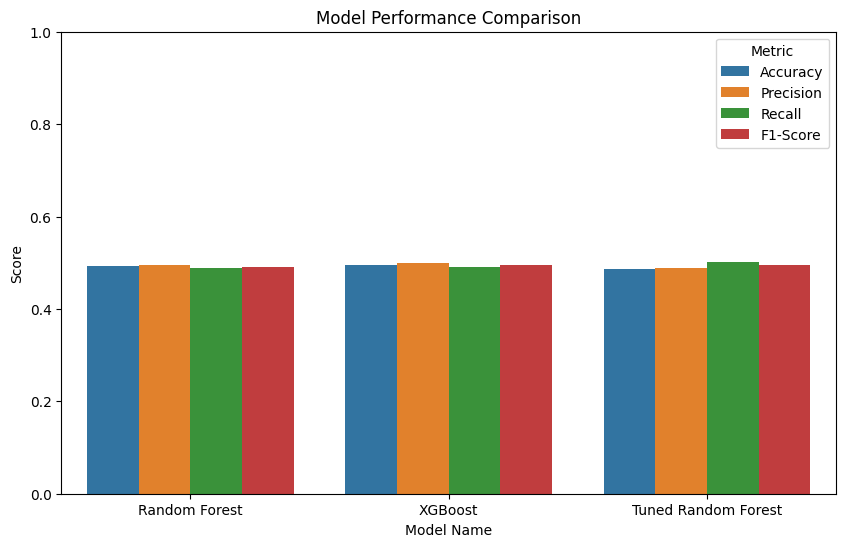

In [32]:
plt.figure(figsize=(10,6))
metrics_plot = metrics_df.melt(id_vars='Model Name', var_name='Metric', value_name='Score')
sns.barplot(data=metrics_plot, x='Model Name', y='Score', hue='Metric')
plt.ylim(0, 1)
plt.title("Model Performance Comparison")
plt.show()

In [19]:
!pip install xgboost


[notice] A new release of pip is available: 25.1.1 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

print("XGBoost Results")
print(classification_report(y_test, y_pred_xgb))


XGBoost Results
              precision    recall  f1-score   support

           0       0.49      0.50      0.50      1989
           1       0.50      0.49      0.49      2011

    accuracy                           0.50      4000
   macro avg       0.50      0.50      0.50      4000
weighted avg       0.50      0.50      0.50      4000



In [30]:
model_metrics["XGBoost"] = {
    "Accuracy": accuracy_score(y_test, y_pred_xgb),
    "Precision": precision_score(y_test, y_pred_xgb),
    "Recall": recall_score(y_test, y_pred_xgb),
    "F1-Score": f1_score(y_test, y_pred_xgb)
}


In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20]
}

grid = GridSearchCV(RandomForestClassifier(), param_grid, scoring='f1', cv=3)
grid.fit(X_train, y_train)

best_rf = grid.best_estimator_
y_pred_best = best_rf.predict(X_test)

print("Tuned Random Forest Results")
print(classification_report(y_test, y_pred_best))


Tuned Random Forest Results
              precision    recall  f1-score   support

           0       0.48      0.47      0.48      1989
           1       0.49      0.50      0.50      2011

    accuracy                           0.49      4000
   macro avg       0.49      0.49      0.49      4000
weighted avg       0.49      0.49      0.49      4000



In [29]:
model_metrics["Tuned Random Forest"] = {
    "Accuracy": accuracy_score(y_test, y_pred_best),
    "Precision": precision_score(y_test, y_pred_best),
    "Recall": recall_score(y_test, y_pred_best),
    "F1-Score": f1_score(y_test, y_pred_best)
}


Results Summary
Random Forest baseline F1: 0.491
XGBoost F1: 0.494
Tuned Random Forest F1: 0.495

Observation
Gradient boosting slightly improves performance.
Hyperparameter tuning gives marginal improvement.
Dataset may need better features for larger gains.